In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from ensemble.sgh import SGH

#from deslib.static.oracle import Oracle
from ensemble.oracle import Oracle

from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier, Perceptron
from tqdm import tqdm
import pandas as pd
import numpy as np
import utils

plt.style.use('ggplot')

ds_name, X, y = utils.data_digits()

seed = 100000
base_learner = Perceptron()
kf = KFold(n_splits=5)
results = {'oracle_accuracy': [], 'oracle_std': [], 'ensemble_length': []}

"""
 - verifique quantas instâncias por classe foram incorretamente classificadas; 
 - verifique quantos hiperplanos por classe foram gerados
"""

pool_classifiers = SGH(base_estimator=base_learner)
scores = list()
fold = 1
for train_index, test_index in kf.split(X):
    #print("Fold %d" % fold)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    pool_classifiers.fit(X_train, y_train)    
    oracle = Oracle(pool_classifiers)
    #oracle.fit(X_train, y_train)
    
    
    score = oracle.score(X_test, y_test)
    scores.append(score)
    fold += 1
    
print("Acc (mean): %.2f" % np.mean(scores))
print("STD: %.2f" % np.std(scores))

Acc (mean): 1.00
STD: 0.00


In [22]:
np.round(np.mean(pool_classifiers.misclassified_data_frames, axis=1))

array([[144., 115.,  88.,  87.,  58.,  29.,  28.,  14.,   0.],
       [144., 115.,  88.,  86.,  58.,  29.,  29.,  15.,   0.],
       [144., 115.,  89.,  87.,  58.,  29.,  29.,  15.,   0.],
       [144., 115.,  89.,  87.,  58.,  29.,  29.,  15.,   0.],
       [144., 115.,  88.,  87.,  58.,  29.,  29.,  15.,   0.]])

In [23]:
misclassified = pd.DataFrame(np.round(np.mean(pool_classifiers.misclassified_data_frames, axis=0)))
misclassified['labels'] = misclassified.index
misclassified.columns = ['H_%s' % it for it in misclassified.columns[:-1]] + [misclassified.columns[-1]]
misclassified

,H_0,H_1,H_2,H_3,H_4,H_5,H_6,H_7,H_8,labels
0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,1.0,0
1,146.0,146.0,8.0,30.0,30.0,30.0,142.0,3.0,1.0,1
2,142.0,142.0,142.0,113.0,113.0,113.0,2.0,1.0,0.0,2
3,146.0,31.0,31.0,59.0,59.0,2.0,1.0,1.0,0.0,3
4,145.0,145.0,145.0,145.0,117.0,1.0,1.0,0.0,0.0,4
5,146.0,146.0,146.0,146.0,30.0,1.0,0.0,0.0,0.0,5
6,145.0,144.0,144.0,144.0,86.0,1.0,0.0,0.0,0.0,6
7,143.0,142.0,117.0,87.0,1.0,0.0,0.0,0.0,0.0,7
8,139.0,112.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,8
9,144.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [9]:
misclassified.to_latex("results/sgh/summary_%s.tex" % ds_name)

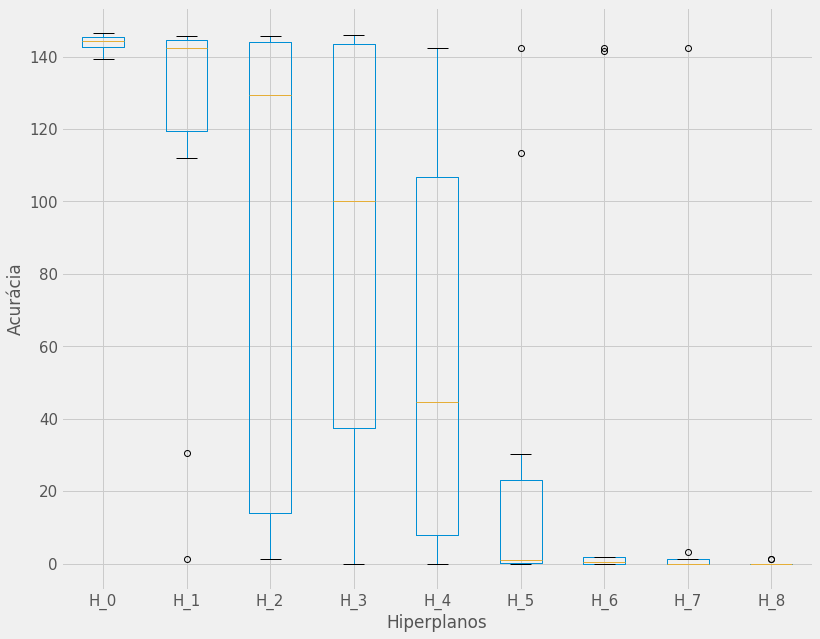

In [10]:
with plt.style.context('fivethirtyeight'):
    misclassified.iloc[:, :-1].boxplot(figsize=(12,10), grid=True, fontsize=15)
    plt.xlabel('Hiperplanos')
    plt.ylabel('Acurácia')
    plt.savefig("results/sgh/boxplot_%s.pdf" % (ds_name))
    plt.show();
    

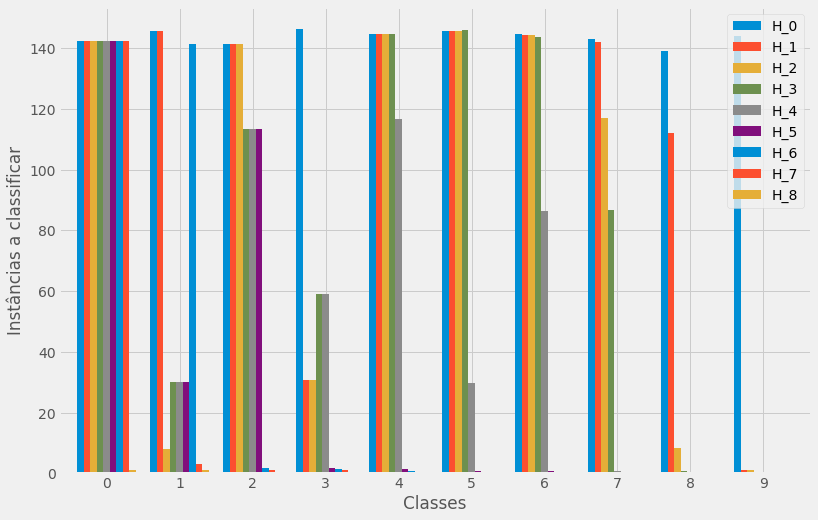

In [11]:
with plt.style.context('fivethirtyeight'):
    misclassified.iloc[:, :-1].plot(kind='bar', width=.80, figsize=(12,8), rot=0)
    plt.xlabel('Classes')
    plt.ylabel('Instâncias a classificar')
    plt.savefig("results/sgh/bar_%s.pdf" % ds_name)
    plt.show();
    

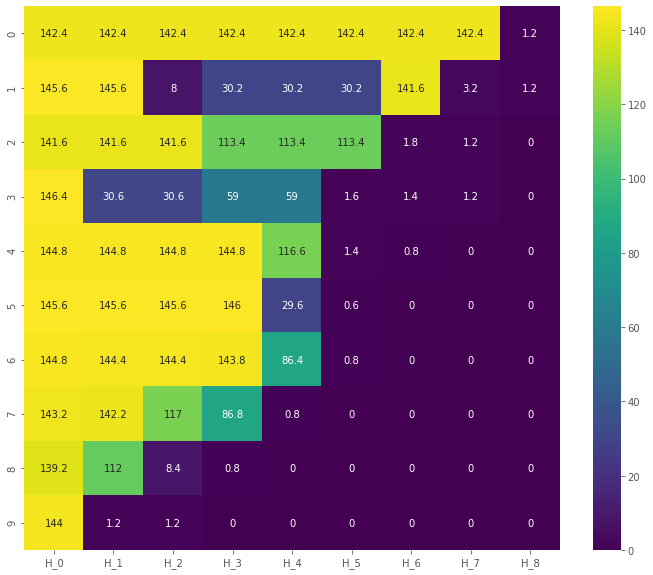

In [13]:
with plt.style.context('ggplot'):   
    plt.figure(figsize=(12,10))
    plt.xlabel('Hiperplanos')
    plt.ylabel('Quantidade média de classes')
    sns.heatmap(misclassified.iloc[:, :-1], annot=True, fmt="g", cmap='viridis')
    plt.savefig("results/sgh/heatmap_%s.pdf" % (ds_name))
    plt.show()